## Preprocessing

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load your dataset
data = pd.read_csv("name_gender_dataset.csv")

# Use relevant columns
data = data[["Name", "Gender"]]

# Encode Gender (Female: 0, Male: 1)
label_encoder = LabelEncoder()
data["Gender"] = label_encoder.fit_transform(data["Gender"])  # Female -> 0, Male -> 1

# Tokenize Names at character level
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data["Name"])
sequences = tokenizer.texts_to_sequences(data["Name"])

# Pad sequences to ensure uniform length
max_length = max(len(name) for name in data["Name"])  # Maximum name length in the dataset
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split the data into training, validation, and test sets (80-10-10 split)
X_train, X_temp, y_train, y_temp = train_test_split(
    padded_sequences, data["Gender"], test_size=0.2, random_state=42, stratify=data["Gender"]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Data preprocessing complete!")
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Data preprocessing complete!
Training set: (117815, 25), Validation set: (14727, 25), Test set: (14727, 25)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define model parameters
vocab_size = len(tokenizer.word_index) + 1  # Total unique characters + 1 for padding
embedding_dim = 16  # Size of the character embeddings
lstm_units = 32  # Number of units in the LSTM layer

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=lstm_units, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification (0: Female, 1: Male)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Number of epochs
    batch_size=32  # Size of training batches
)

# Save the model
model.save("name_gender_model.h5")

Epoch 1/10
3682/3682 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - accuracy: 0.7030 - loss: 0.5694 - val_accuracy: 0.7826 - val_loss: 0.4868
Epoch 2/10
3682/3682 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.7732 - loss: 0.4842 - val_accuracy: 0.7842 - val_loss: 0.4686
Epoch 3/10
3682/3682 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - accuracy: 0.7775 - loss: 0.4772 - val_accuracy: 0.7880 - val_loss: 0.4645
Epoch 4/10
3682/3682 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - accuracy: 0.7833 - loss: 0.4661 - val_accuracy: 0.7913 - val_loss: 0.4539
Epoch 5/10
3682/3682 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.7874 - loss: 0.4566 - val_accuracy: 0.7881 - val_loss: 0.4546
Epoch 6/10
3682/3682 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - accuracy: 0.7938 - loss: 0.4477 - val_accuracy: 0.7971 - val_loss: 0.4448
Epoch 7/10
3682/3682 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.7936 - loss: 0.4465 - val_accuracy: 0.7967 - val_loss: 0.4428
Epoch 8/10
3682/3682 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - accuracy: 0.7968 -

In [6]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8017 - loss: 0.4290
Test Loss: 0.4301, Test Accuracy: 0.7988


In [23]:
# Predict gender for new names
new_names = ["Jonathan", "Sephiroth", "Yura", "Yuri", "Yurinovich", "Rika", "Abel", "Michael", "Ady", "Wiedjaja", "Dale"]
new_sequences = tokenizer.texts_to_sequences(new_names)
new_padded = pad_sequences(new_sequences, maxlen=max_length, padding='post')
predictions = model.predict(new_padded)

for name, prediction in zip(new_names, predictions):
    gender = "Male" if prediction[0] > 0.5 else "Female"
    print(f"Name: {name}, Predicted Gender: {gender}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Name: Jonathan, Predicted Gender: Male
Name: Sephiroth, Predicted Gender: Male
Name: Yura, Predicted Gender: Female
Name: Yuri, Predicted Gender: Female
Name: Yurinovich, Predicted Gender: Male
Name: Rika, Predicted Gender: Female
Name: Abel, Predicted Gender: Male
Name: Michael, Predicted Gender: Male
Name: Ady, Predicted Gender: Female
Name: Wiedjaja, Predicted Gender: Female
Name: Dale, Predicted Gender: Male


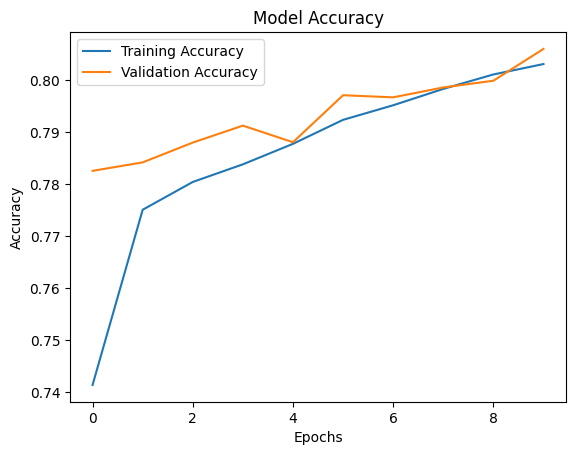

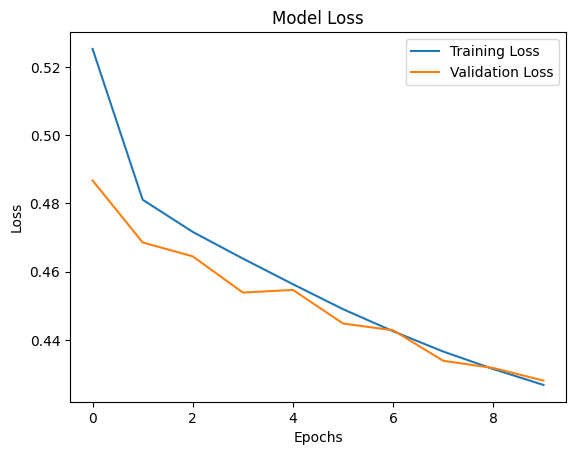

In [24]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
